# Stock price prediction with RNNs

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from skorch import NeuralNetRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [6]:
dataset = pd.read_csv('data/rnn/IBM.csv', index_col="Date", parse_dates=["Date"])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


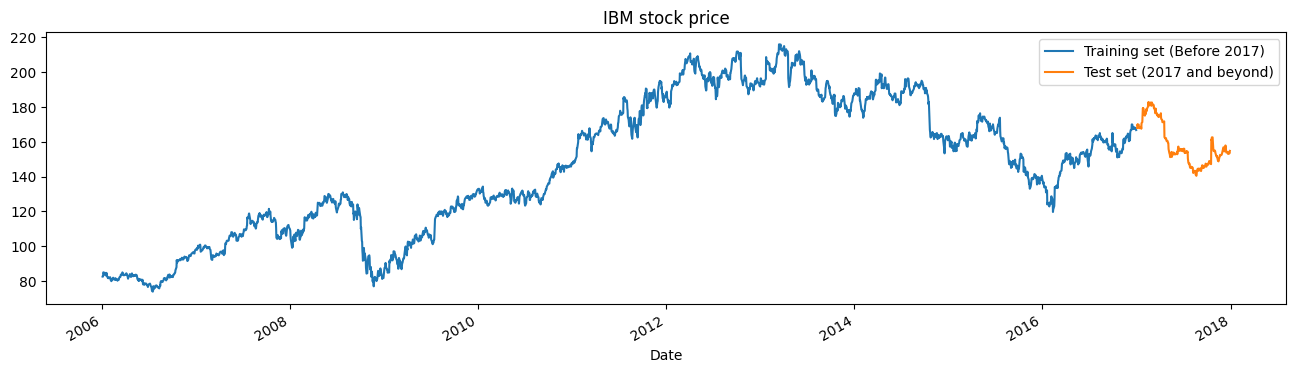

In [7]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [8]:
# Scaling the data
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.transform(test_set)

Create a RNN model to predict the stock price. Plot the predictions on the test set.

In [9]:
def create_sequence(training_set, window_size=60):
    X_train = np.array([training_set[i - window_size:i, 0] for i in range(window_size, len(training_set))])
    y_train = np.array([training_set[i, 0] for i in range(window_size, len(training_set))])
    return X_train, y_train

X_train, y_train = create_sequence(training_set_scaled, window_size=60)
X_test, _ = create_sequence(test_set_scaled)

In [10]:
X_train = torch.tensor(np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)), dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
X_test = torch.tensor(np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1)), dtype=torch.float32)

In [11]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1, num_layers=4):
        super(RNNModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size, num_layers, batch_first=True, nonlinearity="relu")
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size)
        lstm_out, _ = self.rnn(x, h0)
        predictions = self.linear(lstm_out[:, -1, :])  # Take the last time-step output
        return predictions

In [12]:
net = NeuralNetRegressor(
    RNNModel,
    max_epochs=100,
    lr=0.001,
    batch_size=32,
    optimizer=torch.optim.Adam,
)

In [13]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0157        0.0807  0.7700
      2        0.0517        0.1135  0.6747
      3        0.0705        0.1311  0.6740
      4        0.0780        0.1866  0.6790
      5        0.0808        0.2152  0.6602
      6        0.0658        0.1423  0.6750
      7        0.0738        0.2220  0.6758
      8        0.0774        0.2136  0.6579
      9        0.0732        0.2184  0.6663
     10        0.0703        0.1616  0.6745
     11        0.0680        0.1895  0.6703
     12        0.0611        0.1434  0.6632
     13        0.0488        0.1140  0.6833
     14        0.0456        0.1033  0.6659
     15        0.0252        0.0812  0.6664
     16        0.0402        0.0583  0.6771
     17        0.0341        0.0420  0.6663
     18        0.0273        0.0392  0.6738
     19        0.0263        0.0490  0.6830
     20        0.0251        0.0471  0.6624
     21        0.0199        0.0

,module,<class '__main__.RNNModel'>
,criterion,<class 'torch...loss.MSELoss'>
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.001
,max_epochs,100
,batch_size,32
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>
,train_split,<skorch.datas...t 0x30e1ebb60>
,callbacks,None


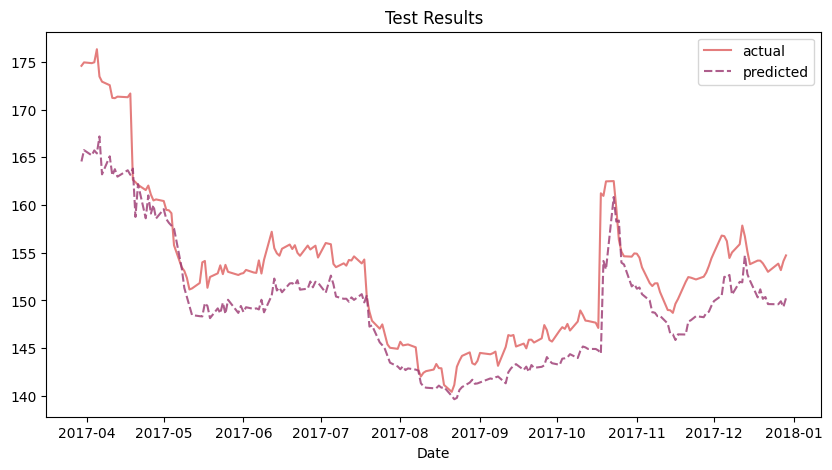

In [21]:
import seaborn as sns

predicted_stock_price = net.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

df_pred = pd.DataFrame(dataset["High"]["2017":])
df_pred.columns=["actual"]
df_pred = df_pred[60:]
df_pred["predicted"] = predicted_stock_price

plt.figure(figsize=(10,5));
sns.lineplot(df_pred,alpha=0.8,palette="flare",linestyle=None);
plt.title("Test Results");